In [1]:
import os
import sys
envname = os.environ['CONDA_DEFAULT_ENV']
if envname=="rigetti":
    path = os.path.abspath("Rigetti/Experiment 2/")
    sys.path.append(path)
elif envname=="cirq":
    path = os.path.abspath("Cirq/Experiment 2/")
    sys.path.append(path)
else:
    path = os.path.abspath("Qiskit/Experiment 2/")
    sys.path.append(path)

In [2]:
import pandas as pd
import numpy as np
from tqdm import *
pd.set_option('display.max_columns', None)

import random
import warnings
import exrex
import math
import json
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from statsmodels.stats.gof import chisquare
warnings.filterwarnings('ignore')

from benchmark_circuits import *
from sklearn.model_selection import train_test_split

load_circuits()

backends = [('FakeAlmaden', 20), ('FakeBoeblingen', 20), ('FakeBrooklyn', 65), ('FakeCairo', 27), ('FakeCambridge', 28), ('FakeCambridgeAlternativeBasis', 28), ('FakeCasablanca', 7), ('FakeGuadalupe', 16), ('FakeHanoi', 27), ('FakeJakarta', 7), ('FakeJohannesburg', 20), ('FakeKolkata', 27), ('FakeLagos', 7), ('FakeManhattan', 65), ('FakeMontreal', 27), ('FakeMumbai', 27), ('FakeNairobi', 7), ('FakeParis', 27), ('FakeRochester', 53), ('FakeSingapore', 20), ('FakeSydney', 27), ('FakeToronto', 27), ('FakeWashington', 127),('rainbow', 23), ('weber', 53),('9q-square', 9)]
BaselineCircuits,CUTs = train_test_split(get_all_circuits(),train_size=0.2,random_state=13)

# # Define QuCAT Oracles

# In[3]:


import rpy2.robjects as robjects
r = robjects.r
r['source']('chisquare.R')

def Uof(observed,expected):
    if len(observed.keys())<1:
        return "F"
    for k in observed.keys():
        if k not in expected.keys():
            return "F"
    return "P"
    
def Wodf(observed,expected):
    test = robjects.globalenv['chisquare']
    try:
        if len(observed)==1 and len(expected)==1:
            return "P"
        
        obs = []
        exp = []
        expected = dict(sorted(expected.items(), key=lambda item: item[0]))
        observed = dict(sorted(observed.items(), key=lambda item: item[0]))
        for k in set(observed.keys()).intersection(expected.keys()):
            obs.append(observed[k])
            exp.append(expected[k])
        
        for k in set(expected.keys()).difference(observed.keys()):
            exp.append(expected[k])
        
        if len(obs)<len(exp):
#             epsilon = 1024-sum(obs)
#             try:
#                 epsilon = epsilon/(len(exp)-len(obs))
#             except:
#                 epsilon = 0
            obs.extend([0 for t in range(len(exp)-len(obs))])
        
        #obs = [int(o*100) for o in obs]
        
        df_result_r = test(robjects.FloatVector(obs),robjects.FloatVector(exp))
        p = np.array(df_result_r)[0]
#         print("expected_o:",expected)
#         print("observed_o:",observed)
#         print("expected:",exp)
#         print("observed:",obs)
#         print("p-value",p)
        if p<0.01:
            return "F"
        else:
            return "P"
    except Exception as e:
        print(e)
        return "F"
    
def convertNaQp2QuCAT_notation(output,value="prob"):
    program_specification = {}
    for x in output["probability"]:
        program_specification[x["bin"]] = x[value]
    return program_specification

def filter_output(output,model,count=True):
    prediction_output = {}
    for state in output["probability"]:
        all_other_probs = sum([x["prob"] for x in output["probability"] if x["bin"]!=state["bin"]])
        odr = state["odds"]
        pos = state["prob"]
        pof = 1-pos
        df = pd.DataFrame([[pof,odr,pos]],columns=["POF","ODR","POS"])
        prediction = predictor.predict(df)[0][0]
        prediction_output[state["bin"]] = [state["count"],prediction]
        
    filtered_output = {}
    # clamp output to 0 and 1
    for k in prediction_output.keys():
        if prediction_output[k][1]>1:
            if np.abs(prediction_output[k][1]-1)<0.2:
                prediction_output[k][1] = min(prediction_output[k][1],1) 
                filtered_output[k] = prediction_output[k]
            else:
                if prediction_output[k][1]>2:
                    prediction_output[k][1] = prediction_output[k][1]%1
                    filtered_output[k] = prediction_output[k]
                
        elif prediction_output[k][1]<0:
            prediction_output[k][1] = 0.0
            filtered_output[k] = prediction_output[k]
        else:
            filtered_output[k] = prediction_output[k]

    # check for irrelevent values
#     if len(filtered_output.keys())>2:
#         temp = {}
#         maxvalue = max([filtered_output[k][0] for k in filtered_output.keys()])
#         for k in filtered_output.keys():
#             if (filtered_output[k][0]/maxvalue)>=0.35:
#                 temp[k] = filtered_output[k]
#         filtered_output =  temp
    
    temp1 = {}
    total = sum([filtered_output[k][0] for k in filtered_output.keys()])
    for k in filtered_output.keys():
        if filtered_output[k][1]==0:
            continue
        if count:
            temp1[k] = int(filtered_output[k][1]*1024)#int(filtered_output[k][1]*total)
        else:
            temp1[k] = filtered_output[k][1]
    filtered_output =  temp1
        
            
    return filtered_output,prediction_output


def filter_output_all(outputs,model,count=True):
    results = []
    for output in outputs:
        prediction_output = {}
        df = pd.DataFrame(columns=["POF","ODR","POS"])
        for state in output["probability"]:
            all_other_probs = sum([x["prob"] for x in output["probability"] if x["bin"]!=state["bin"]])
            odr = state["odds"]
            pos = state["prob"]
            pof = 1-pos
            df = df.append({"POF":pof,"ODR":odr,"POS":pos},ignore_index=True)
        
        predictions = predictor.predict(df)
        
        for state,prediction in zip(output["probability"],predictions):
            prediction_output[state["bin"]] = [state["count"],prediction[0]]
        
        #print(predictions,prediction_output)
        
        filtered_output = {}
        # clamp output to 0 and 1
        for k in prediction_output.keys():
            if prediction_output[k][1]>1:
                if np.abs(prediction_output[k][1]-1)<0.2:
                    prediction_output[k][1] = min(prediction_output[k][1],1) 
                    filtered_output[k] = prediction_output[k]
                else:
                    if prediction_output[k][1]>2:
                        prediction_output[k][1] = prediction_output[k][1]%1
                        filtered_output[k] = prediction_output[k]

            elif prediction_output[k][1]<0:
                prediction_output[k][1] = 0.0
                filtered_output[k] = prediction_output[k]
            else:
                filtered_output[k] = prediction_output[k]

    
        temp1 = {}
        total = sum([filtered_output[k][0] for k in filtered_output.keys()])
        for k in filtered_output.keys():
            if filtered_output[k][1]==0:
                continue
            if count:
                temp1[k] = int(filtered_output[k][1]*1024)#int(filtered_output[k][1]*total)
            else:
                temp1[k] = filtered_output[k][1]
        filtered_output =  temp1
        
        results.append((filtered_output,prediction_output))
    
    return results


def default_inner_template():
    return {"uof":[],"uof_w":[],"wodf":[],"wodf_w":[]}


# # Evaluate Noise QuCAT

# In[4]:


with open("Qiskit/Experiment 2/results/RQ2A.json","r") as file:
    RQ2A = json.load(file)

with open("Cirq/Experiment 2/results/RQ2A.json","r") as file:
    RQ2Ac = json.load(file)

with open("Rigetti/Experiment 2/results/RQ2A.json","r") as file:
    RQ2Ar = json.load(file)

for k in RQ2Ac.keys():
    RQ2A[k] = RQ2Ac[k]

for k in RQ2Ar.keys():
    RQ2A[k] = RQ2Ar[k]



# In[5]:


with open("Qiskit/Experiment 2/results/RQ2B.json","r") as file:
    RQ2B = json.load(file)

with open("Cirq/Experiment 2/results/RQ2B.json","r") as file:
    RQ2Bc = json.load(file)

with open("Rigetti/Experiment 2/results/RQ2B.json","r") as file:
    RQ2Br = json.load(file)

for k in RQ2Bc.keys():
    RQ2B[k] = RQ2Bc[k]

for k in RQ2Br.keys():
    RQ2B[k] = RQ2Br[k]

# # Evaluate filter QuCAT

# In[6]:


with open("Qiskit/Experiment 2/results/RQ2C.json","r") as file:
    RQ2C = json.load(file)

with open("Cirq/Experiment 2/results/RQ2C.json","r") as file:
    RQ2Cc = json.load(file)

with open("Rigetti/Experiment 2/results/RQ2C.json","r") as file:
    RQ2Cr = json.load(file)

for k in RQ2Cc.keys():
    RQ2C[k] = RQ2Cc[k]

for k in RQ2Cr.keys():
    RQ2C[k] = RQ2Cr[k]

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 55.25it/s]


0 707 93 581 1740 79


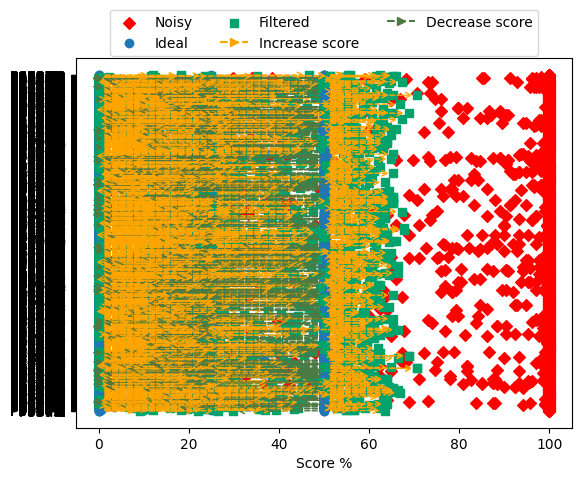

In [3]:
# In[7]:


data1 = pd.DataFrame(columns=["Program","Original_score","Mutant 1 score","Mutant 2 score","Mutant 3 score"])
for program in CUTs:
    org,m1,m2,m3 = [],[],[],[]
    for key in RQ2B.keys():
        for prog in RQ2B[key]:
            p_key = list(prog.keys())[0]
            if program == p_key:
                org.append(prog[p_key]["original_score"])
                m1.append(prog[p_key]["mutant1_score"])
                m2.append(prog[p_key]["mutant2_score"])
                m3.append(prog[p_key]["mutant3_score"])
                break
    
    org = np.mean(org)
    m1 = np.mean(m1)
    m2 = np.mean(m2)
    m3 = np.mean(m3)  
    data1 = pd.concat([data1, pd.DataFrame({"Program":program,
                        "Original_score":org,
                        "Mutant 1 score":m1,
                        "Mutant 2 score":m2,
                        "Mutant 3 score":m3},index=[0])], ignore_index=True)
data1


# In[8]:


data2 = pd.DataFrame(columns=["Program","Original_score","Mutant 1 score","Mutant 2 score","Mutant 3 score"])
for program in CUTs:
    org,m1,m2,m3 = [],[],[],[]
    for key in RQ2A.keys():
        for prog in RQ2A[key]:
            p_key = list(prog.keys())[0]
            if program == p_key:
                org.append(prog[p_key]["original_score"])
                m1.append(prog[p_key]["mutant1_score"])
                m2.append(prog[p_key]["mutant2_score"])
                m3.append(prog[p_key]["mutant3_score"])
                break
    
    org = np.mean(org)
    m1 = np.mean(m1)
    m2 = np.mean(m2)
    m3 = np.mean(m3)  
    data2 = pd.concat([data2, pd.DataFrame({"Program":program,
                        "Original_score":org,
                        "Mutant 1 score":m1,
                        "Mutant 2 score":m2,
                        "Mutant 3 score":m3},index=[0])], ignore_index=True)
    
data2


# In[9]:


data3 = pd.DataFrame(columns=["Program","Original_score","Mutant 1 score","Mutant 2 score","Mutant 3 score"])
for program in CUTs:
    org,m1,m2,m3 = [],[],[],[]
    for key in RQ2C.keys():
        for prog in RQ2C[key]:
            p_key = list(prog.keys())[0]
            if program == p_key:
                org.append(prog[p_key]["original_score"])
                m1.append(prog[p_key]["mutant1_score"])
                m2.append(prog[p_key]["mutant2_score"])
                m3.append(prog[p_key]["mutant3_score"])
                break
    
    org = np.mean(org)
    m1 = np.mean(m1)
    m2 = np.mean(m2)
    m3 = np.mean(m3)  
    data3 = pd.concat([data3, pd.DataFrame({"Program":program,
                        "Original_score":org,
                        "Mutant 1 score":m1,
                        "Mutant 2 score":m2,
                        "Mutant 3 score":m3},index=[0])], ignore_index=True)
data3


# # Statistical Test

# In[10]:


data_for_stat = pd.DataFrame(columns=["Program","Backend","Original_I","Mutant_1_I","Mutant_2_I","Mutant_3_I","Original_F",
                             "Mutant_1_F","Mutant_2_F","Mutant_3_F"])
for program in CUTs:
    for key in RQ2B.keys():
        org,m1,m2,m3 = 0,0,0,0
        for prog in RQ2B[key]:
            p_key = list(prog.keys())[0]
            if program == p_key:
                org = prog[p_key]["original_score"]
                m1  = prog[p_key]["mutant1_score"]
                m2  = prog[p_key]["mutant2_score"]
                m3  = prog[p_key]["mutant3_score"]
                break
                
        org3,m13,m23,m33 = 0,0,0,0
        for prog in RQ2C[key]:
            p_key = list(prog.keys())[0]
            if program == p_key:
                org3 = prog[p_key]["original_score"]
                m13  = prog[p_key]["mutant1_score"]
                m23  = prog[p_key]["mutant2_score"]
                m33  = prog[p_key]["mutant3_score"]
                break

        data_for_stat = pd.concat([data_for_stat, pd.DataFrame({"Program":program,
                            "Backend":key,
                            "Original_I":org,
                            "Mutant_1_I":m1,
                            "Mutant_2_I":m2,
                            "Mutant_3_I":m3,
                            "Mutant_1_F":m13,
                            "Mutant_2_F":m23,
                            "Mutant_3_F":m33,
                            "Original_F":org3
                           },index=[0])], ignore_index=True)

        
data_for_stat.head()


# In[11]:


import rpy2.robjects as robjects
r = robjects.r
r.library('effsize')
r['source']('A12.R')
test = robjects.globalenv['A12']

stat_data_original = pd.DataFrame(columns=["Program","Pvalue","Avalue","Mag"])
stat_data_mutant1 = pd.DataFrame(columns=["Program","Pvalue","Avalue","Mag"])
stat_data_mutant2 = pd.DataFrame(columns=["Program","Pvalue","Avalue","Mag"])
stat_data_mutant3 = pd.DataFrame(columns=["Program","Pvalue","Avalue","Mag"])

index = data_for_stat.groupby("Program").indices
for program in index.keys():
    oresult = stats.mannwhitneyu(x=data_for_stat.loc[index[program],"Original_I"],y=data_for_stat.loc[index[program],"Original_F"])
    
    df_result_r = test(robjects.FloatVector(data_for_stat.loc[index[program],"Original_I"].values),
                       robjects.FloatVector(data_for_stat.loc[index[program],"Original_F"].values))
    
    mag = str(df_result_r[2]).split("\n")[0].split()[-1]
    oeffect = float(str(df_result_r[3]).split()[-1])
    oeffect = oeffect                                 #smaller values mean better performance
    stat_data_original = pd.concat([stat_data_original,pd.DataFrame({"Program":program,
                                  "Pvalue":oresult.pvalue,
                                  "Avalue":oeffect,
                                  "Mag":mag},index=[0])],ignore_index=True)
    
    oresult = stats.mannwhitneyu(x=data_for_stat.loc[index[program],"Mutant_1_I"],y=data_for_stat.loc[index[program],"Mutant_1_F"])
    
    df_result_r = test(robjects.FloatVector(data_for_stat.loc[index[program],"Mutant_1_I"].values),
                       robjects.FloatVector(data_for_stat.loc[index[program],"Mutant_1_F"].values))
    
    mag = str(df_result_r[2]).split("\n")[0].split()[-1]
    oeffect = float(str(df_result_r[3]).split()[-1])
    oeffect = oeffect                                 #smaller values mean better performance
    stat_data_mutant1 = pd.concat([stat_data_mutant1,pd.DataFrame({"Program":program,
                                  "Pvalue":oresult.pvalue,
                                  "Avalue":oeffect,
                                  "Mag":mag},index=[0])],ignore_index=True)
    
    oresult = stats.mannwhitneyu(x=data_for_stat.loc[index[program],"Mutant_2_I"],y=data_for_stat.loc[index[program],"Mutant_2_F"])
    
    df_result_r = test(robjects.FloatVector(data_for_stat.loc[index[program],"Mutant_2_I"].values),
                       robjects.FloatVector(data_for_stat.loc[index[program],"Mutant_2_F"].values))
    
    mag = str(df_result_r[2]).split("\n")[0].split()[-1]
    oeffect = float(str(df_result_r[3]).split()[-1])
    oeffect = oeffect                                 #smaller values mean better performance
    stat_data_mutant2 = pd.concat([stat_data_mutant2,pd.DataFrame({"Program":program,
                                  "Pvalue":oresult.pvalue,
                                  "Avalue":oeffect,
                                  "Mag":mag},index=[0])],ignore_index=True)
    
    oresult = stats.mannwhitneyu(x=data_for_stat.loc[index[program],"Mutant_3_I"],y=data_for_stat.loc[index[program],"Mutant_3_F"])
    
    df_result_r = test(robjects.FloatVector(data_for_stat.loc[index[program],"Mutant_3_I"].values),
                       robjects.FloatVector(data_for_stat.loc[index[program],"Mutant_3_F"].values))
    
    mag = str(df_result_r[2]).split("\n")[0].split()[-1]
    oeffect = float(str(df_result_r[3]).split()[-1])
    oeffect = oeffect                                 #smaller values mean better performance
    stat_data_mutant3 = pd.concat([stat_data_mutant3,pd.DataFrame({"Program":program,
                                  "Pvalue":oresult.pvalue,
                                  "Avalue":oeffect,
                                  "Mag":mag},index=[0])],ignore_index=True)


# In[12]:

stat_data_original.round(2).to_csv("results2/RQ2_statistics_original_programs.csv",index=False)
stat_data_mutant1.round(2).to_csv("results2/RQ2_statistics_faulty1_programs.csv",index=False)
stat_data_mutant2.round(2).to_csv("results2/RQ2_statistics_faulty2_programs.csv",index=False)
stat_data_mutant3.round(2).to_csv("results2/RQ2_statistics_faulty3_programs.csv",index=False)

stat_data_original


# In[13]:


stat_data_mutant1


# In[14]:


stat_data_mutant2


# In[15]:


stat_data_mutant3


# In[16]:


df = pd.DataFrame(columns=["Programs","Score","Type"])
for i in range(data1.shape[0]):
    P = data1.loc[i,"Program"]
    S = data1.loc[i,"Original_score"]
    T = "Ideal"
    df = pd.concat([df,pd.DataFrame({"Programs":"{} ".format(P),"Score":S,"Type":T},index=[0])],ignore_index=True)
    P = data1.loc[i,"Program"]
    S = data1.loc[i,"Mutant 1 score"]
    T = "Ideal"
    df = pd.concat([df,pd.DataFrame({"Programs":"{} F1".format(P),"Score":S,"Type":T},index=[0])],ignore_index=True)
    P = data1.loc[i,"Program"]
    S = data1.loc[i,"Mutant 2 score"]
    T = "Ideal"
    df = pd.concat([df,pd.DataFrame({"Programs":"{} F2".format(P),"Score":S,"Type":T},index=[0])],ignore_index=True)
    P = data1.loc[i,"Program"]
    S = data1.loc[i,"Mutant 3 score"]
    T = "Ideal"
    df = pd.concat([df,pd.DataFrame({"Programs":"{} F3".format(P),"Score":S,"Type":T},index=[0])],ignore_index=True)
    
for i in range(data2.shape[0]):
    P = data2.loc[i,"Program"]
    S = data2.loc[i,"Original_score"]
    T = "Noisy"
    df = pd.concat([df,pd.DataFrame({"Programs":"{} ".format(P),"Score":S,"Type":T},index=[0])],ignore_index=True)
    P = data2.loc[i,"Program"]
    S = data2.loc[i,"Mutant 1 score"]
    T = "Noisy"
    df = pd.concat([df,pd.DataFrame({"Programs":"{} F1".format(P),"Score":S,"Type":T},index=[0])],ignore_index=True)
    P = data2.loc[i,"Program"]
    S = data2.loc[i,"Mutant 2 score"]
    T = "Noisy"
    df = pd.concat([df,pd.DataFrame({"Programs":"{} F2".format(P),"Score":S,"Type":T},index=[0])],ignore_index=True)
    P = data2.loc[i,"Program"]
    S = data2.loc[i,"Mutant 3 score"]
    T = "Noisy"
    df = pd.concat([df,pd.DataFrame({"Programs":"{} F3".format(P),"Score":S,"Type":T},index=[0])],ignore_index=True)
    
for i in range(data3.shape[0]):
    P = data3.loc[i,"Program"]
    S = data3.loc[i,"Original_score"]
    T = "Filtered"
    df = pd.concat([df,pd.DataFrame({"Programs":"{} ".format(P),"Score":S,"Type":T},index=[0])],ignore_index=True)
    P = data3.loc[i,"Program"]
    S = data3.loc[i,"Mutant 1 score"]
    T = "Filtered"
    df = pd.concat([df,pd.DataFrame({"Programs":"{} F1".format(P),"Score":S,"Type":T},index=[0])],ignore_index=True)
    P = data3.loc[i,"Program"]
    S = data3.loc[i,"Mutant 2 score"]
    T = "Filtered"
    df = pd.concat([df,pd.DataFrame({"Programs":"{} F2".format(P),"Score":S,"Type":T},index=[0])],ignore_index=True)
    P = data3.loc[i,"Program"]
    S = data3.loc[i,"Mutant 3 score"]
    T = "Filtered"
    df = pd.concat([df,pd.DataFrame({"Programs":"{} F3".format(P),"Score":S,"Type":T},index=[0])],ignore_index=True)

df.head()


# In[17]:


case1o = 0
case2o = 0
case3o = 0
case1f = 0
case2f = 0
case3f = 0

for program in df["Programs"].unique():
    if "F1" in program or "F2" in program or "F3" in program:
        ideal = df.loc[(df.Type == "Ideal") & (df.Programs == program)]["Score"].values[0]
        filtered = df.loc[(df.Type == "Filtered") & (df.Programs == program)]["Score"].values[0]
        if ideal-filtered<0:
            case3f+=1
        elif ideal-filtered==0:
            case1f+=1
    else:
        ideal = df.loc[(df.Type == "Ideal") & (df.Programs == program)]["Score"].values[0]
        filtered = df.loc[(df.Type == "Filtered") & (df.Programs == program)]["Score"].values[0]
        if ideal-filtered<0:
            case3o+=1
        elif ideal-filtered==0:
            case1o+=1


for program in df["Programs"].unique():
    if "F1" in program or "F2" in program or "F3" in program:
        ideal = df.loc[(df.Type == "Ideal") & (df.Programs == program)]["Score"].values[0]
        filtered = df.loc[(df.Type == "Filtered") & (df.Programs == program)]["Score"].values[0]
        if ideal-filtered>0:
            case2f+=1
    else:
        ideal = df.loc[(df.Type == "Ideal") & (df.Programs == program)]["Score"].values[0]
        filtered = df.loc[(df.Type == "Filtered") & (df.Programs == program)]["Score"].values[0]
        if ideal-filtered>0:
            case2o+=1


# In[18]:


label = {}
revlabel = {}
i=0
for x in df["Programs"].unique():
    label[x] = i
    revlabel[i] = x
    i+=1

df["y"] = 0

for i in range(df.shape[0]):
    df.loc[i,"y"] = label[df.loc[i,"Programs"]]

fig, ax = plt.subplots()

ax.scatter(x=df[df["Type"]=="Noisy"]["Score"],y=df[df["Type"]=="Noisy"]["y"],c="r",marker="D",label="Noisy")

ax.scatter(x=df[df["Type"]=="Ideal"]["Score"],y=df[df["Type"]=="Ideal"]["y"],label="Ideal")
ticks = [x for x in range(df["y"].max()+1)]
ticklabels = [revlabel[x] if x in label.values() else "" for x in range(df["y"].max()+1)]
ax.set_yticks(ticks)
ax.set_yticklabels(ticklabels)
ax.set_xlabel("Score %")



ax.scatter(x=df[df["Type"]=="Filtered"]["Score"],y=df[df["Type"]=="Filtered"]["y"],c="#00A36C",marker="s",label="Filtered")

for program in df["Programs"].unique():
    ideal = df.loc[(df.Type == "Ideal") & (df.Programs == program)]["Score"].values[0]
    filtered = df.loc[(df.Type == "Filtered") & (df.Programs == program)]["Score"].values[0]
    if ideal-filtered<0:
        plt.annotate("",xy=(filtered-1,label[program]),xytext=(ideal+1.5,label[program]),xycoords="data",
                     arrowprops={"arrowstyle" : "->", "linestyle" : "--",
                                 "linewidth" : 1, "shrinkA": 0, "shrinkB": 0,
                                "color":'orange'})
        
    if ideal-filtered>0:
        plt.annotate("",xy=(filtered+1,label[program]),xytext=(ideal-1.5,label[program]),xycoords="data",
                     arrowprops={"arrowstyle" : "->", "linestyle" : "--",
                                 "linewidth" : 1, "shrinkA": 0, "shrinkB": 0,
                                "color":'#4F7942'})
        
        


plt.plot([], [], '-->',c="orange", label="Increase score")
plt.plot([], [], '-->',c="#4F7942", label="Decrease score")
plt.legend(bbox_to_anchor =(0.5, 1.15), ncol = 3,loc=9)
plt.savefig("results2/RQ2B1.png",dpi=600,bbox_inches='tight')


# In[19]:


print(case2o,case3o,case1o,case2f,case3f,case1f)


# In[45]:


data = pd.DataFrame(columns=["Program","Precision_O","Recall_O","Precision_M1","Recall_M1",
                            "Precision_M2","Recall_M2","Precision_M3","Recall_M3",
                            "F1_O","F1_M1","F1_M2","F1_M3"])

# data = pd.DataFrame(columns=["Program","Precision_O","Recall_O","Precision_M1","Recall_M1",
#                             "Precision_M2","Recall_M2","Precision_M3","Recall_M3",
#                             "F1_O","F1_baseline_O","F1_M1","F1_baseline_M1","F1_M2","F1_baseline_M2","F1_M3","F1_baseline_M3"])

total_inputs = []
filter_FP = []
filter_FN = []


for i in range(data1.shape[0]):
    algo = get_circuit_class_object(data1.loc[i,"Program"])
    total = len(algo.get_full_inputs())
    total_inputs.append(total)
    total_inputs.append(total)
    total_inputs.append(total)
    total_inputs.append(total)
    
    Ipositives = total-((data1.loc[i,"Original_score"]/100)*total)
    Inegatives = (data1.loc[i,"Original_score"]/100)*total
    Fpositives = total-((data3.loc[i,"Original_score"]/100)*total)
    Fnegatives = (data3.loc[i,"Original_score"]/100)*total
    TP = abs(Ipositives-abs(Ipositives-Fpositives))
    FP = Fpositives-TP
    TN = abs(Inegatives-abs(Inegatives-Fnegatives))
    FN = Fnegatives-TN
    precision = TP/(TP+FP)
    recall = TP/(TP+FN) 
    data.loc[i,"Precision_O"] = precision
    data.loc[i,"Recall_O"] = recall
    f1 = 2 * (precision * recall) / (precision + recall)
    data.loc[i,"F1_O"] = f1
    
    filter_FP.append(FP)
    filter_FN.append(FN)
    
    Ipositives = (data1.loc[i,"Mutant 1 score"]/100)*total
    Inegatives = total-Ipositives
    Fpositives = (data3.loc[i,"Mutant 1 score"]/100)*total
    Fnegatives = total-Fpositives
    TP = abs(Ipositives-abs(Ipositives-Fpositives))
    FP = Fpositives-TP
    TN = abs(Inegatives-abs(Inegatives-Fnegatives))
    FN = Fnegatives-TN
    precision = TP/(TP+FP)
    recall = TP/(TP+FN) 
    data.loc[i,"Precision_M1"] = precision
    data.loc[i,"Recall_M1"] = recall
    f1 = 2 * (precision * recall) / (precision + recall)
    data.loc[i,"F1_M1"] = f1
    
    filter_FP.append(FP)
    filter_FN.append(FN)
    
    Ipositives = (data1.loc[i,"Mutant 2 score"]/100)*total
    Inegatives = total-Ipositives    
    Fpositives = (data3.loc[i,"Mutant 2 score"]/100)*total
    Fnegatives = total-Fpositives
    TP = abs(Ipositives-abs(Ipositives-Fpositives))
    FP = Fpositives-TP
    TN = abs(Inegatives-abs(Inegatives-Fnegatives))
    FN = Fnegatives-TN
    precision = TP/(TP+FP)
    recall = TP/(TP+FN) 
    data.loc[i,"Precision_M2"] = precision
    data.loc[i,"Recall_M2"] = recall
    f1 = 2 * (precision * recall) / (precision + recall)
    data.loc[i,"F1_M2"] = f1
    
    filter_FP.append(FP)
    filter_FN.append(FN)
    
    Ipositives = (data1.loc[i,"Mutant 3 score"]/100)*total
    Inegatives = total-Ipositives
    Fpositives = (data3.loc[i,"Mutant 3 score"]/100)*total
    Fnegatives = total-Fpositives
    TP = abs(Ipositives-abs(Ipositives-Fpositives))
    FP = Fpositives-TP
    TN = abs(Inegatives-abs(Inegatives-Fnegatives))
    FN = Fnegatives-TN
    precision = TP/(TP+FP)
    recall = TP/(TP+FN) 
    data.loc[i,"Precision_M3"] = precision
    data.loc[i,"Recall_M3"] = recall
    f1 = 2 * (precision * recall) / (precision + recall)
    data.loc[i,"F1_M3"] = f1
    
    filter_FP.append(FP)
    filter_FN.append(FN)
    
    data.loc[i,"Program"] = data1.loc[i,"Program"]
    
data = data.fillna(0)


# In[46]:


data["F1_O F1_M1 F1_M2 F1_M3".split()]


# In[47]:


F1_filtered_score = data["F1_O F1_M1 F1_M2 F1_M3".split()].stack().mean()
Precision_filtered = data["Precision_O Precision_M1 Precision_M2 Precision_M3".split()].stack().mean()
Recall_filtered = data["Recall_O Recall_M1 Recall_M2 Recall_M3".split()].stack().mean()

# In[56]:


totalF = sum(total_inputs)


# In[49]:


filterFP = sum(filter_FP)
filterFN = sum(filter_FN)


# # For noise

# In[50]:


data = pd.DataFrame(columns=["Program","Precision_O","Recall_O","Precision_M1","Recall_M1",
                            "Precision_M2","Recall_M2","Precision_M3","Recall_M3",
                            "F1_O","F1_M1","F1_M2","F1_M3"])

# data = pd.DataFrame(columns=["Program","Precision_O","Recall_O","Precision_M1","Recall_M1",
#                             "Precision_M2","Recall_M2","Precision_M3","Recall_M3",
#                             "F1_O","F1_baseline_O","F1_M1","F1_baseline_M1","F1_M2","F1_baseline_M2","F1_M3","F1_baseline_M3"])

total_inputs = []
Noise_FP = []
Noise_FN = []

for i in range(data1.shape[0]):
    algo = get_circuit_class_object(data1.loc[i,"Program"])
    total = len(algo.get_full_inputs())
    total_inputs.append(total)
    
    Ipositives = total-((data1.loc[i,"Original_score"]/100)*total)
    Inegatives = (data1.loc[i,"Original_score"]/100)*total
    Fpositives = total-((data2.loc[i,"Original_score"]/100)*total)
    Fnegatives = (data2.loc[i,"Original_score"]/100)*total
    TP = abs(Ipositives-abs(Ipositives-Fpositives))
    FP = Fpositives-TP
    TN = abs(Inegatives-abs(Inegatives-Fnegatives))
    FN = Fnegatives-TN
    precision = TP/(TP+FP)
    recall = TP/(TP+FN) 
    data.loc[i,"Precision_O"] = precision
    data.loc[i,"Recall_O"] = recall
    f1 = 2 * (precision * recall) / (precision + recall)
    data.loc[i,"F1_O"] = f1
    
    Noise_FP.append(FP)
    Noise_FN.append(FN)
    
    Ipositives = (data1.loc[i,"Mutant 1 score"]/100)*total
    Inegatives = total-Ipositives
    Fpositives = (data2.loc[i,"Mutant 1 score"]/100)*total
    Fnegatives = total-Fpositives
    TP = abs(Ipositives-abs(Ipositives-Fpositives))
    FP = Fpositives-TP
    TN = abs(Inegatives-abs(Inegatives-Fnegatives))
    FN = Fnegatives-TN
    precision = TP/(TP+FP)
    recall = TP/(TP+FN) 
    data.loc[i,"Precision_M1"] = precision
    data.loc[i,"Recall_M1"] = recall
    f1 = 2 * (precision * recall) / (precision + recall)
    data.loc[i,"F1_M1"] = f1
    
    Noise_FP.append(FP)
    Noise_FN.append(FN)
    
    Ipositives = (data1.loc[i,"Mutant 2 score"]/100)*total
    Inegatives = total-Ipositives    
    Fpositives = (data2.loc[i,"Mutant 2 score"]/100)*total
    Fnegatives = total-Fpositives
    TP = abs(Ipositives-abs(Ipositives-Fpositives))
    FP = Fpositives-TP
    TN = abs(Inegatives-abs(Inegatives-Fnegatives))
    FN = Fnegatives-TN
    precision = TP/(TP+FP)
    recall = TP/(TP+FN) 
    data.loc[i,"Precision_M2"] = precision
    data.loc[i,"Recall_M2"] = recall
    f1 = 2 * (precision * recall) / (precision + recall)
    data.loc[i,"F1_M2"] = f1
    
    Noise_FP.append(FP)
    Noise_FN.append(FN)
    
    Ipositives = (data1.loc[i,"Mutant 3 score"]/100)*total
    Inegatives = total-Ipositives
    Fpositives = (data2.loc[i,"Mutant 3 score"]/100)*total
    Fnegatives = total-Fpositives
    TP = abs(Ipositives-abs(Ipositives-Fpositives))
    FP = Fpositives-TP
    TN = abs(Inegatives-abs(Inegatives-Fnegatives))
    FN = Fnegatives-TN
    precision = TP/(TP+FP)
    recall = TP/(TP+FN) 
    data.loc[i,"Precision_M3"] = precision
    data.loc[i,"Recall_M3"] = recall
    f1 = 2 * (precision * recall) / (precision + recall)
    data.loc[i,"F1_M3"] = f1
    
    Noise_FP.append(FP)
    Noise_FN.append(FN)
    
    data.loc[i,"Program"] = data1.loc[i,"Program"]
    
data = data.fillna(0)


# In[51]:


F1_noise_score = data["F1_O F1_M1 F1_M2 F1_M3".split()].stack().mean()
Precision_noise = data["Precision_O Precision_M1 Precision_M2 Precision_M3".split()].stack().mean()
Recall_noise = data["Recall_O Recall_M1 Recall_M2 Recall_M3".split()].stack().mean()

# In[52]:


NoiseFP = sum(Noise_FP)
NoiseFN = sum(Noise_FN)


# In[54]:


with open("results2/RQ2_cases.txt","w") as file:
    file.write("Original Case1 = {}\n".format(case1o))
    file.write("Original Case2 = {}\n".format(case2o))
    file.write("Original Case3 = {}\n".format(case3o))
    file.write("Faulty Case1 = {}\n".format(case1f))
    file.write("Faulty Case2 = {}\n".format(case2f))
    file.write("Faulty Case3 = {}\n".format(case3f))
    
    file.write("Original Significant = {}\n".format(sum(stat_data_original.Pvalue<0.05)))
    file.write("Faulty Significant = {}\n".format(sum(stat_data_mutant1.Pvalue<0.05)+sum(stat_data_mutant2.Pvalue<0.05)+sum(stat_data_mutant3.Pvalue<0.05)))
    file.write("Original Large = {}\n".format(sum(stat_data_original.Mag=="large")))
    file.write("Faulty Large = {}\n".format(sum(stat_data_mutant1.Mag=="large")+sum(stat_data_mutant2.Mag=="large")+sum(stat_data_mutant3.Mag=="large")))
    
    file.write("F1_filtered = {}\n".format(F1_filtered_score))
    file.write("F1_Noise = {}\n".format(F1_noise_score))
    file.write("Precision_filtered = {}\n".format(F1_filtered_score))
    file.write("Precision_Noise = {}\n".format(F1_noise_score))
    file.write("Recall_filtered = {}\n".format(F1_filtered_score))
    file.write("Recall_Noise = {}\n".format(F1_noise_score))

    file.write("FalsePositives Filtered = {}\n".format(filterFP))
    file.write("FalseNegatives Filtered = {}\n".format(filterFN))

    file.write("FalsePositives Noise = {}\n".format(NoiseFP))
    file.write("FalseNegatives Noise = {}\n".format(NoiseFN))
    
    file.write("Total Inputs = {}\n".format(totalF))


# In[ ]:

In [5]:
2 * (0.60 * 0.60) / (0.60 + 0.60)

0.6